# Incremental training on target dataset

### Sagemaker groundtruth labelling

Using Amazon Sagemaker Groud Truth labeling job to label our data (messi, neymar, epic games videos players cropped), sagemaker will generate a manifest file, which is the annotations labels, in json form. In this notebook, we will use ground truth labeling job manifest data to train the model

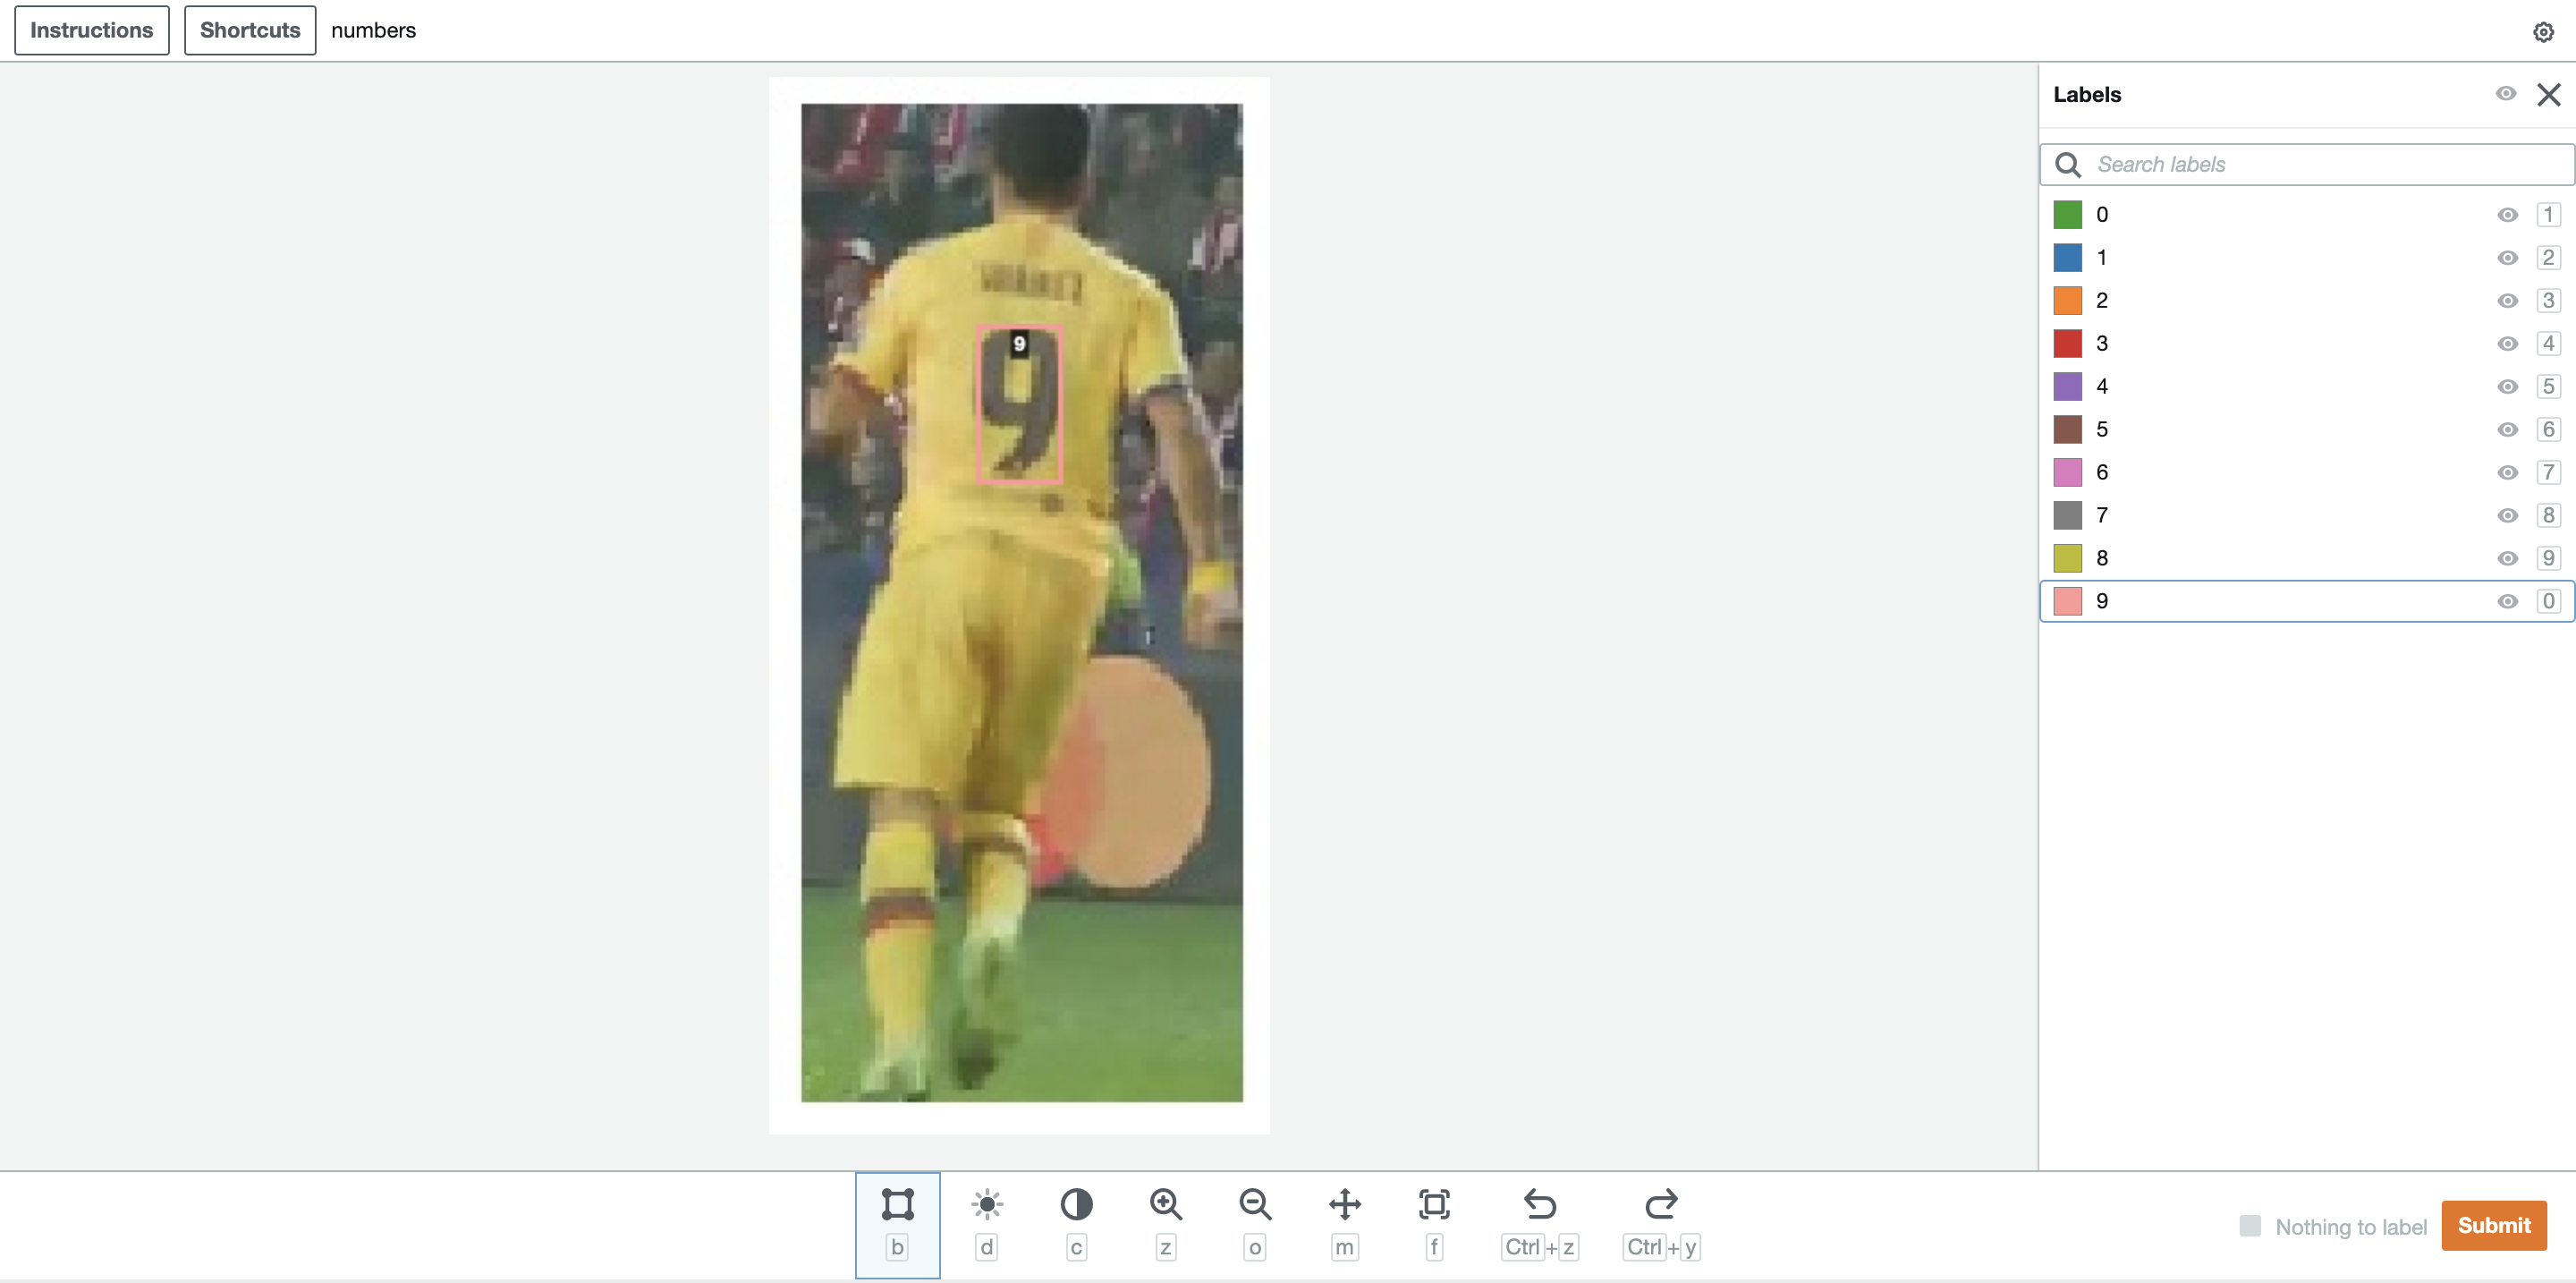

In [1]:
from IPython import display
display.Image("GTlabeling.png")

### Set up

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

In [1]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
import json

role = get_execution_role()
sess = sagemaker.Session()
s3 = boto3.resource("s3")

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    boto3.Session().region_name, "object-detection", repo_version="latest"
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


### Required Inputs

*Be sure to edit the file names and paths below for your own use!*

In [4]:
data_bucket_name = "number-detector-data-0909"
training_bucket_name = "incremental-training-0910"  # Replace with your bucket name.
s3_incretrain_output_path = "s3://{}/output-EMN-SHVN".format(training_bucket_name)  # Replace with your desired output directory.

The setup section concludes with a few more definitions and constants.

In [5]:
# Defines paths for use in the training job request.
# Manifest data generated by grond truth labeling job
s3_emn_train_data_path = "s3://number-detector-data-0909/train-label-0909/number-detector-emn-train-labelingjob/manifests/output/output.manifest"
s3_emn_validation_data_path = "s3://number-detector-data-0909/val-label-0909/number-detector-emn-val-labelingjob/manifests/output/output.manifest"

print("Augmented manifest for training data: {}".format(s3_emn_train_data_path))
print("Augmented manifest for validation data: {}".format(s3_emn_validation_data_path))

Augmented manifest for training data: s3://number-detector-data-0909/train-label-0909/number-detector-emn-train-labelingjob/manifests/output/output.manifest
Augmented manifest for validation data: s3://number-detector-data-0909/val-label-0909/number-detector-emn-val-labelingjob/manifests/output/output.manifest


### Understanding Manifest Augmented Dataset Format

The first field will always be either `source` our `source-ref`. This defines an individual dataset object. The name of the second field depends on whether the labeling job was created from the SageMaker console or through the Ground Truth API. If the job was created through the console, then the name of the field will be the labeling job name. Alternatively, if the job was created through the API, then this field maps to the `LabelAttributeName` parameter in the API. 

The training job request requires a parameter called `AttributeNames`. This should be a two-element list of strings, where the first string is "source-ref", and the second string is the label attribute name from the augmented manifest. This corresponds to the <span style="color:blue">blue text</span> in the example above. In this case, we would define `attribute_names = ["source-ref", "labeling-job-name"]`.

*Be sure to carefully inspect your augmented manifest so that you can define the `attribute_names` variable below.*

### Preview Input Data

Let's read the augmented manifest so we can inspect its contents to better understand the format.

In [6]:
augmented_manifest_s3_key = s3_emn_train_data_path.split(data_bucket_name)[1][1:]
s3_obj = s3.Object(data_bucket_name, augmented_manifest_s3_key)
augmented_manifest = s3_obj.get()["Body"].read().decode("utf-8")
augmented_manifest_lines = augmented_manifest.split("\n")

num_training_samples = len(
    augmented_manifest_lines
)  # Compute number of training samples for use in training job request.


print("total training samples: {}".format(num_training_samples))
print("Preview of Augmented Manifest File Contents")
print("-------------------------------------------")
print("\n")

for i in range(2):
    print("Line {}".format(i + 1))
    print(augmented_manifest_lines[i])
    print("\n")

total training samples: 204
Preview of Augmented Manifest File Contents
-------------------------------------------


Line 1
{"source-ref":"s3://number-detector-data-0909/train-0909/Clip1Frame00031_1_05_09.jpg","number-detector-emn-train-labelingjob":{"image_size":[{"width":108,"height":231,"depth":3}],"annotations":[{"class_id":1,"top":54.599999999999994,"left":38.6,"height":37,"width":14.799999999999997},{"class_id":7,"top":54.80000000000001,"left":52.4,"height":36.79999999999998,"width":19.199999999999996}]},"number-detector-emn-train-labelingjob-metadata":{"objects":[{"confidence":0.81},{"confidence":0.86}],"class-map":{"1":"1","7":"7"},"type":"groundtruth/object-detection","human-annotated":"yes","creation-date":"2021-09-08T17:38:20.298128","job-name":"labeling-job/number-detector-emn-train-labelingjob"}}


Line 2
{"source-ref":"s3://number-detector-data-0909/train-0909/Clip1Frame00061_1_05_09.jpg","number-detector-emn-train-labelingjob":{"image_size":[{"width":113,"height":231,"d

In [7]:
train_attribute_name = ["source-ref", "number-detector-emn-train-labelingjob"]  # labeling job name.
val_attribute_name = ["source-ref", "number-detector-emn-val-labelingjob"]  # labeling job name.

### Prepare EMN data channels

Prepare SVHN trained model data

In [8]:
# Retrieve SVHN training job 
TrainingJobName ="object-detection-2021-09-22-07-40-46-799"

previous_model = sagemaker.estimator.Estimator.attach(TrainingJobName)

# Use the output model from the previous job.  
s3_model_data = previous_model.model_data


2021-09-22 09:27:47 Starting - Preparing the instances for training
2021-09-22 09:27:47 Downloading - Downloading input data
2021-09-22 09:27:47 Training - Training image download completed. Training in progress.
2021-09-22 09:27:47 Uploading - Uploading generated training model
2021-09-22 09:27:47 Completed - Training job completed


Creating training and validation data channels using the manifest data.

In [9]:
# using training and validation labeling job output
emn_train_data = sagemaker.session.s3_input(s3_emn_train_data_path, 
                                              distribution='FullyReplicated', 
                                              content_type='application/x-recordio', 
                                              s3_data_type='AugmentedManifestFile', 
                                              attribute_names= train_attribute_name,
                                              input_mode='Pipe',
                                              record_wrapping='RecordIO',
                                             )

emn_validation_data = sagemaker.session.s3_input(s3_emn_validation_data_path, 
                                                   distribution='FullyReplicated', 
                                                   content_type='application/x-recordio', 
                                                   s3_data_type='AugmentedManifestFile', 
                                                   attribute_names=val_attribute_name,
                                                   input_mode='Pipe',
                                                   record_wrapping='RecordIO',
                                                  )

model_data = sagemaker.session.s3_input(s3_model_data, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-sagemaker-model', 
                                        s3_data_type='S3Prefix')

# In addition to two data channels, add a 'model' channel for the training.
data_channels = {'train': emn_train_data, 'validation': emn_validation_data, 'model': model_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Prepare Esitimator for tuning 5 epochs

Normally, in AWS machine learning, tuning hyperparameters means runing parallel training jobs at the same time, then select the bset performing training job from all tuning outputs. However, to save time from waiting for multiples training jobs to complete, we will create an seperate esitimator just for a short tuning epochs to get the best performimg hyperparameters' value and use them on just one training job.

Set up the estimator for tuning, with the following configuration:

In [10]:
# tuning estimator configuration
emn_no_tuner_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_incretrain_output_path,
                                         sagemaker_session=sess)

emn_no_tuner_model.set_hyperparameters(base_network='resnet-50',
                                 num_classes=10,
                                 use_pretrained_model=1,
                                 epochs=5,
                                 optimizer='adam',
                                 image_shape=300,
                                 label_width=350,
                                 num_training_samples=num_training_samples)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Tuning Hyperparameter

Next, we set up the tuning job with the following configuration:

- the hyperparameters that SageMaker Automatic Model Tuning will tune: learning_rate, mini_batch_size
- the maximum number of training jobs it will run to optimize the objective metric: 5
- the number of parallel training jobs that will run in the tuning job: 2
- the objective metric that Automatic Model Tuning will use: validation:accuracy

In [11]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# tuner will tune hyperparameter between these range
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01),
    "mini_batch_size": IntegerParameter(8,32),
}

# tuner will compare results using mAP value
objective_metric_name = "validation:mAP"

emn_no_tuner = HyperparameterTuner(
    emn_no_tuner_model,
    objective_metric_name,
    hyperparameter_ranges,
    objective_type="Maximize",
    max_jobs=5,
    max_parallel_jobs=2,
)

Launch hyperparameter tuning job

In [12]:
emn_no_tuner.fit(data_channels, include_cls_metadata=False)

..............................................................................................................................................................................................!


Once the tuning job finishes, we can bring in a table of metrics.

In [13]:
tuning_job_name = emn_no_tuner._current_job_name

tuner_parent_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
if not tuner_parent_metrics.dataframe().empty:
    df_parent = tuner_parent_metrics.dataframe().sort_values(
        ["FinalObjectiveValue"], ascending=False
    )

df_parent

,learning_rate,mini_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.001000,10.0,object-detection-210924-0552-005-c88da9e2,Completed,0.267070,2021-09-24 06:05:55+00:00,2021-09-24 06:07:57+00:00,122.0
4,0.001194,9.0,object-detection-210924-0552-001-a5dc3f5b,Completed,0.195338,2021-09-24 05:55:23+00:00,2021-09-24 05:57:43+00:00,140.0
3,0.001625,20.0,object-detection-210924-0552-002-5735fdb7,Completed,0.143962,2021-09-24 05:55:51+00:00,2021-09-24 05:57:52+00:00,121.0
1,0.002812,8.0,object-detection-210924-0552-004-40bd5b19,Completed,0.004620,2021-09-24 06:01:00+00:00,2021-09-24 06:03:01+00:00,121.0
2,0.004154,8.0,object-detection-210924-0552-003-aa875215,Completed,0.000685,2021-09-24 06:00:46+00:00,2021-09-24 06:03:11+00:00,145.0


### Prepare estimator for training 60 epochs

Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a sageMaker.estimator.Estimator object. This estimator will launch the training job.

In [19]:
# estimator configuration for training
emn_no_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_incretrain_output_path,
                                         sagemaker_session=sess)

# use the best-performed parameters in the tuning session
emn_no_model.set_hyperparameters(base_network='resnet-50',
                                 num_classes=10,
                                 mini_batch_size = 10,#"16"
                                 use_pretrained_model=1,
                                 epochs=60,
                                 learning_rate= 0.001000, #"0.001"
                                 optimizer='adam',
                                 image_shape=300,
                                 label_width=350,
                                 num_training_samples=num_training_samples)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Use the best parameters to train

In [20]:
emn_no_model.fit(inputs=new_data_channels, logs=True)

2021-09-24 06:29:53 Starting - Starting the training job...
2021-09-24 06:30:16 Starting - Launching requested ML instancesProfilerReport-1632464992: InProgress
......
2021-09-24 06:31:16 Starting - Preparing the instances for training......
2021-09-24 06:32:18 Downloading - Downloading input data...
2021-09-24 06:32:37 Training - Downloading the training image...
2021-09-24 06:33:20 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[09/24/2021 06:33:24 INFO 139761083627328] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training_samples': '', 'imag

[06:33:49] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:33:49] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:33:49 INFO 139761083627328] #quality_metric: host=algo-1, epoch=1, batch=21 train cross_entropy <loss>=(0.7729018800326404)
[09/24/2021 06:33:49 INFO 139761083627328] #quality_metric: host=algo-1, epoch=1, batch=21 train smooth_l1 <loss>=(0.3284131741338922)
[09/24/2021 06:33:49 INFO 139761083627328] Round of batches complete
[09/24/2021 06:33:49 INFO 139761083627328] Updated the metrics
[06:33:51] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flav

[06:34:10] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:34:11] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:34:11 INFO 139761083627328] #quality_metric: host=algo-1, epoch=5, batch=21 train cross_entropy <loss>=(0.7741952961933306)
[09/24/2021 06:34:11 INFO 139761083627328] #quality_metric: host=algo-1, epoch=5, batch=21 train smooth_l1 <loss>=(0.31207717642571187)
[09/24/2021 06:34:11 INFO 139761083627328] Round of batches complete
[09/24/2021 06:34:11 INFO 139761083627328] Updated the metrics
[06:34:13] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-fla

[06:34:31] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:34:32] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:34:32 INFO 139761083627328] #quality_metric: host=algo-1, epoch=9, batch=21 train cross_entropy <loss>=(0.7023785556054014)
[09/24/2021 06:34:32 INFO 139761083627328] #quality_metric: host=algo-1, epoch=9, batch=21 train smooth_l1 <loss>=(0.28804877758700576)
[09/24/2021 06:34:32 INFO 139761083627328] Round of batches complete
[09/24/2021 06:34:32 INFO 139761083627328] Updated the metrics
[06:34:34] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-fla

[06:34:53] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:34:53] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:34:53 INFO 139761083627328] #quality_metric: host=algo-1, epoch=13, batch=21 train cross_entropy <loss>=(0.6592794111510571)
[09/24/2021 06:34:53 INFO 139761083627328] #quality_metric: host=algo-1, epoch=13, batch=21 train smooth_l1 <loss>=(0.25588846936517834)
[09/24/2021 06:34:53 INFO 139761083627328] Round of batches complete
[09/24/2021 06:34:53 INFO 139761083627328] Updated the metrics
[06:34:55] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-f

[06:35:13] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:35:13] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:35:13 INFO 139761083627328] #quality_metric: host=algo-1, epoch=17, batch=21 train cross_entropy <loss>=(0.6315022743552741)
[09/24/2021 06:35:13 INFO 139761083627328] #quality_metric: host=algo-1, epoch=17, batch=21 train smooth_l1 <loss>=(0.265325787901147)
[09/24/2021 06:35:13 INFO 139761083627328] Round of batches complete
[09/24/2021 06:35:14 INFO 139761083627328] Updated the metrics
[06:35:15] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-fla

[06:35:34] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:35:34] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:35:34 INFO 139761083627328] #quality_metric: host=algo-1, epoch=21, batch=21 train cross_entropy <loss>=(0.6769686728530789)
[09/24/2021 06:35:34 INFO 139761083627328] #quality_metric: host=algo-1, epoch=21, batch=21 train smooth_l1 <loss>=(0.28596580724538484)
[09/24/2021 06:35:34 INFO 139761083627328] Round of batches complete
[09/24/2021 06:35:34 INFO 139761083627328] Updated the metrics
[06:35:36] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-f

[06:36:00] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:36:00] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:36:00 INFO 139761083627328] #quality_metric: host=algo-1, epoch=26, batch=21 train cross_entropy <loss>=(0.7850051301041829)
[09/24/2021 06:36:00 INFO 139761083627328] #quality_metric: host=algo-1, epoch=26, batch=21 train smooth_l1 <loss>=(0.33188611207549107)
[09/24/2021 06:36:00 INFO 139761083627328] Round of batches complete
[09/24/2021 06:36:00 INFO 139761083627328] Updated the metrics
[06:36:02] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-f

[06:36:21] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:36:21] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:36:21 INFO 139761083627328] #quality_metric: host=algo-1, epoch=30, batch=21 train cross_entropy <loss>=(0.6981719691282625)
[09/24/2021 06:36:21 INFO 139761083627328] #quality_metric: host=algo-1, epoch=30, batch=21 train smooth_l1 <loss>=(0.28450049746568035)
[09/24/2021 06:36:21 INFO 139761083627328] Round of batches complete
[09/24/2021 06:36:21 INFO 139761083627328] Updated the metrics
[06:36:23] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-f

[06:36:42] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:36:42] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:36:42 INFO 139761083627328] #quality_metric: host=algo-1, epoch=34, batch=21 train cross_entropy <loss>=(0.6564169189941261)
[09/24/2021 06:36:42 INFO 139761083627328] #quality_metric: host=algo-1, epoch=34, batch=21 train smooth_l1 <loss>=(0.26050357005042485)
[09/24/2021 06:36:42 INFO 139761083627328] Round of batches complete
[09/24/2021 06:36:42 INFO 139761083627328] Updated the metrics
[06:36:44] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-f

[06:37:02] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:37:03] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:37:03 INFO 139761083627328] #quality_metric: host=algo-1, epoch=38, batch=21 train cross_entropy <loss>=(0.613172355885512)
[09/24/2021 06:37:03 INFO 139761083627328] #quality_metric: host=algo-1, epoch=38, batch=21 train smooth_l1 <loss>=(0.2550056031477277)
[09/24/2021 06:37:03 INFO 139761083627328] Round of batches complete
[09/24/2021 06:37:03 INFO 139761083627328] Updated the metrics
[06:37:05] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-fla

[06:37:23] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:37:23] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:37:23 INFO 139761083627328] #quality_metric: host=algo-1, epoch=42, batch=21 train cross_entropy <loss>=(0.5616271780171526)
[09/24/2021 06:37:23 INFO 139761083627328] #quality_metric: host=algo-1, epoch=42, batch=21 train smooth_l1 <loss>=(0.2396743897529292)
[09/24/2021 06:37:23 INFO 139761083627328] Round of batches complete
[09/24/2021 06:37:23 INFO 139761083627328] Updated the metrics
[06:37:25] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-fl

[06:37:44] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:37:44] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:37:44 INFO 139761083627328] #quality_metric: host=algo-1, epoch=46, batch=21 train cross_entropy <loss>=(0.6063695335138204)
[09/24/2021 06:37:44 INFO 139761083627328] #quality_metric: host=algo-1, epoch=46, batch=21 train smooth_l1 <loss>=(0.26535004369553233)
[09/24/2021 06:37:44 INFO 139761083627328] Round of batches complete
[09/24/2021 06:37:44 INFO 139761083627328] Updated the metrics
[06:37:46] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-f

[06:38:04] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:38:04] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:38:04 INFO 139761083627328] #quality_metric: host=algo-1, epoch=50, batch=21 train cross_entropy <loss>=(0.7582087104665485)
[09/24/2021 06:38:04 INFO 139761083627328] #quality_metric: host=algo-1, epoch=50, batch=21 train smooth_l1 <loss>=(0.32029668576586107)
[09/24/2021 06:38:04 INFO 139761083627328] Round of batches complete
[09/24/2021 06:38:05 INFO 139761083627328] Updated the metrics
[06:38:06] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-f

[06:38:25] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:38:25] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:38:25 INFO 139761083627328] #quality_metric: host=algo-1, epoch=54, batch=21 train cross_entropy <loss>=(0.777508546733468)
[09/24/2021 06:38:25 INFO 139761083627328] #quality_metric: host=algo-1, epoch=54, batch=21 train smooth_l1 <loss>=(0.308736160619935)
[09/24/2021 06:38:25 INFO 139761083627328] Round of batches complete
[09/24/2021 06:38:25 INFO 139761083627328] Updated the metrics
[06:38:27] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flav


2021-09-24 06:38:58 Uploading - Uploading generated training model[06:38:46] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[06:38:46] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIterators/AIApplicationsPipeIterators-1.0.1276.0/AL2_x86_64/generic-flavor/src/data_iter/src/ease_det_image_iter.cpp:88: No more data read from PIPE, reaching end of PIPE
[09/24/2021 06:38:46 INFO 139761083627328] #quality_metric: host=algo-1, epoch=58, batch=21 train cross_entropy <loss>=(0.5658156167307208)
[09/24/2021 06:38:46 INFO 139761083627328] #quality_metric: host=algo-1, epoch=58, batch=21 train smooth_l1 <loss>=(0.24458259028773155)
[09/24/2021 06:38:46 INFO 139761083627328] Round of batches complete
[09/24/2021 06:38:46 INFO 139761083627328] Updated the metrics
[06:38:48] /opt/brazil-pkg-cache/packages/AIApplicationsPipeIt

### Visualise Training logs

In [21]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "validation mAP <score>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Maximum mAP: %f " % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Mean Avg Precision (mAP)")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="mAP")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()

mAP tracking for job: object-detection-2021-09-24-06-29-52-948
Maximum mAP: 0.634975 


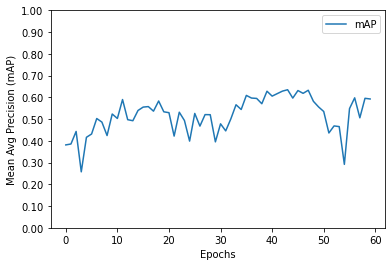

In [22]:
plot_object_detection_log(emn_no_model, "mAP tracking for job: " + emn_no_model._current_job_name)

In [24]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log_loss(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "train smooth_l1 <loss>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Mnimum loss: %f " % min(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="Loss")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()

Loss tracking for job: object-detection-2021-09-24-06-29-52-948
Mnimum loss: 0.227466 


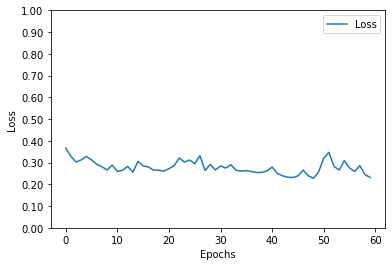

In [25]:
plot_object_detection_log_loss(emn_no_model, "Loss tracking for job: " + emn_no_model._current_job_name)